# Tratamento do Conteúdo das Licitações

### 1. Análise da Estrutura do Texto

O objetivo aqui é entender características referente a coluna "objeto" de cada registro de contrato de licitação. Ao entendermos melhor o estrutura do conteúdo do "objeto" podemos identificar melhor como tratar a sua semântica.

Portanto primeiro vamos começar importando as bibliotecas necessárias e lendo os arquivos referente aos contratos de licitações:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('./input/licitacoes/'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./input/licitacoes/' + f) / 1000000, 2)) + 'MB')

# File sizes
licitacoes_2011_2015.xls      22.0MB
licitacoes_2016_2017.csv      4.53MB
licitacoes_2016_2017.xls      7.08MB


No momento, para o restante da analise iremos usar os contratos de licitações de 2016 a 2017. Em uma proxima atualização voltamos a considerar todo o historico desde 2011.

Abaixo notamos que aproximadamente metade dos contratos aparecem mais de 1 vez. **Precisamos identificar depois o motivo destas recorrências ou duplicações.**

Total de Licitações: 11442
Número de contratos que aparecem 1 vez: 6517
Número de contratos que aparecem 2 vezes ou mais: 1495
Número de contratos que aparecem 2 vezes apenas: 958
Número de contratos que aparecem 3 vezes apenas: 330



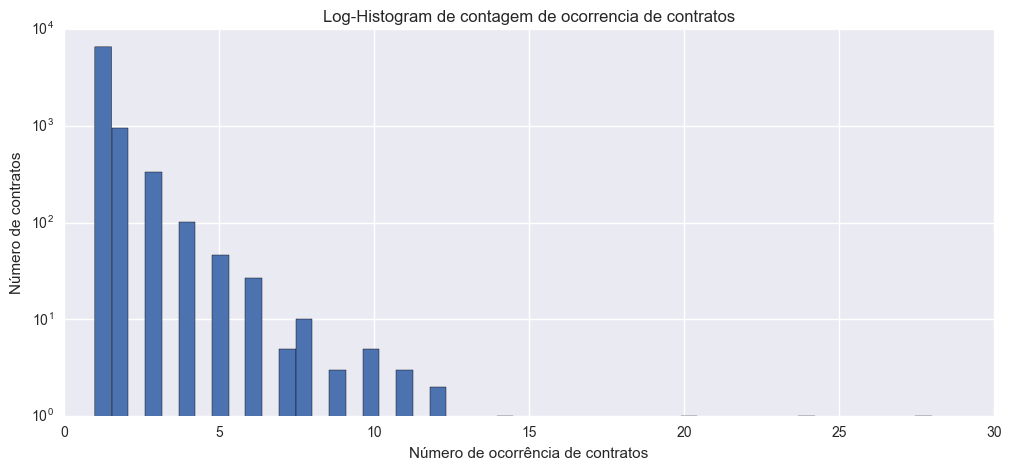

In [16]:
lc_recent = pd.read_csv('./input/licitacoes/licitacoes_2016_2017.csv')
print('Total de Licitações: {}'.format(len(lc_recent)))
qids = pd.Series(lc_recent['enum'].tolist())
print('Número de contratos que aparecem 1 vez: {}'.format(np.sum(qids.value_counts() == 1)))
print('Número de contratos que aparecem 2 vezes ou mais: {}'.format(np.sum(qids.value_counts() > 1)))
print('Número de contratos que aparecem 2 vezes apenas: {}'.format(np.sum(qids.value_counts() == 2)))
print('Número de contratos que aparecem 3 vezes apenas: {}'.format(np.sum(qids.value_counts() == 3)))
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram de contagem de ocorrencia de contratos')
plt.xlabel('Número de ocorrência de contratos')
plt.ylabel('Número de contratos')
print()

Na analise a seguir notamos que a média de caracteres é aproximadamente 160 caracteres. Seguindo uma cauda longa após os 400 caracteres. **Uma recomendação seria impor um tamanho fixo de caracteres para o Objeto notando que existem poucos casos acima de 400, e raros casos acima de 600. Esta alteração poderia refletir numa melhoria para todo o processo de contratação evitando interferência ou "barulho" destes objetos com longas descrições.**

mean-lics 158.89 std-lics 133.08 max-lics 1025.00


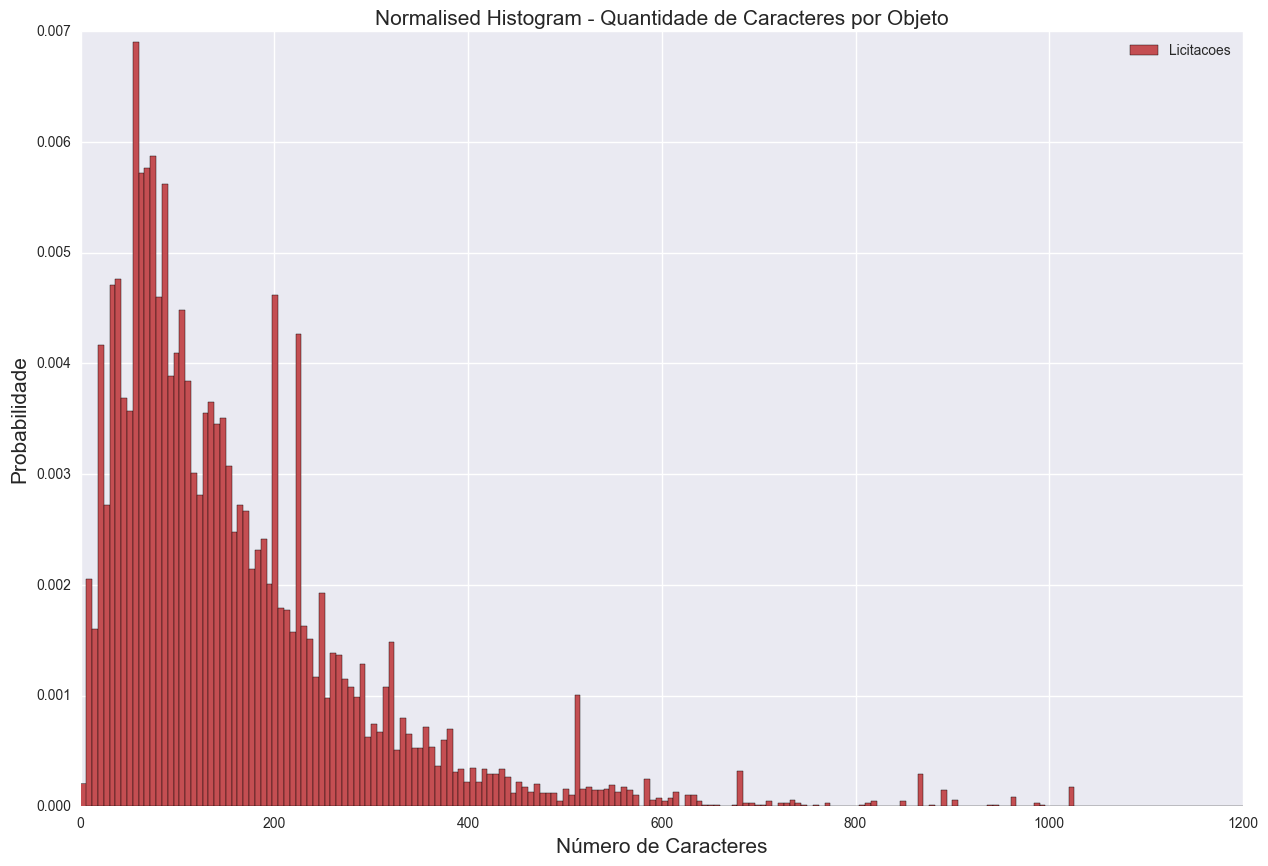

In [18]:
lics_qs = pd.Series(lc_recent['objeto'].tolist()).astype(str)

dist_lics = lics_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_lics, bins=200, range=[0, 1200], color=pal[2], normed=True, label='Licitacoes')
plt.title('Normalised Histogram - Quantidade de Caracteres por Objeto', fontsize=15)
plt.legend()
plt.xlabel('Número de Caracteres', fontsize=15)
plt.ylabel('Probabilidade', fontsize=15)

print('mean-lics {:.2f} std-lics {:.2f} max-lics {:.2f}'.format(dist_lics.mean(), dist_lics.std(), dist_lics.max()))

mean-lics 23.33 std-lics 19.37 max-lics 181.00


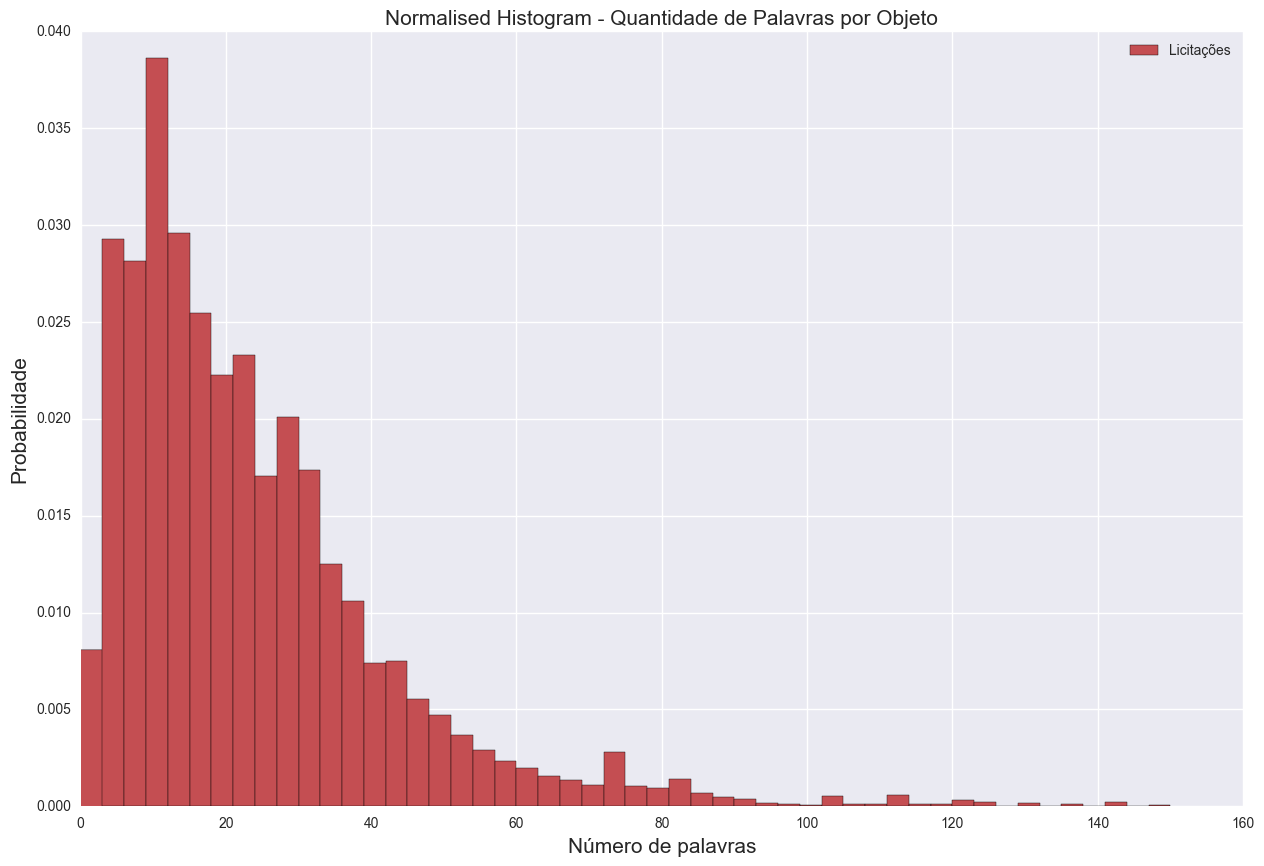

In [19]:
dist_lics = lics_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_lics, bins=50, range=[0, 150], color=pal[2], normed=True, label='Licitações')
plt.title('Normalised Histogram - Quantidade de Palavras por Objeto', fontsize=15)
plt.legend()
plt.xlabel('Número de palavras', fontsize=15)
plt.ylabel('Probabilidade', fontsize=15)

print('mean-lics {:.2f} std-lics {:.2f} max-lics {:.2f}'.format(dist_lics.mean(), dist_lics.std(), dist_lics.max()))

Na nuvem de palavras abaixo notamos as palavras mais recorrentes em "Objeto". 

Os principais são referentes ao tipo da licitação, o que indique que a maioria dos contratos pode ser referente a serviços e nao produtos: "Contratação", "Prestação", "Serviços", "Manutenção". Esse ponto é importante pois é mais dificil definir uma tabela de preços ou valor médio para serviços do que para preços de produtos.

Outras palavras recorrentes em destaque se referem aos orgão de Saúde e Educação: "Criança", "Hospital", "Saúde", "Educação".

(-0.5, 1439.5, 1079.5, -0.5)

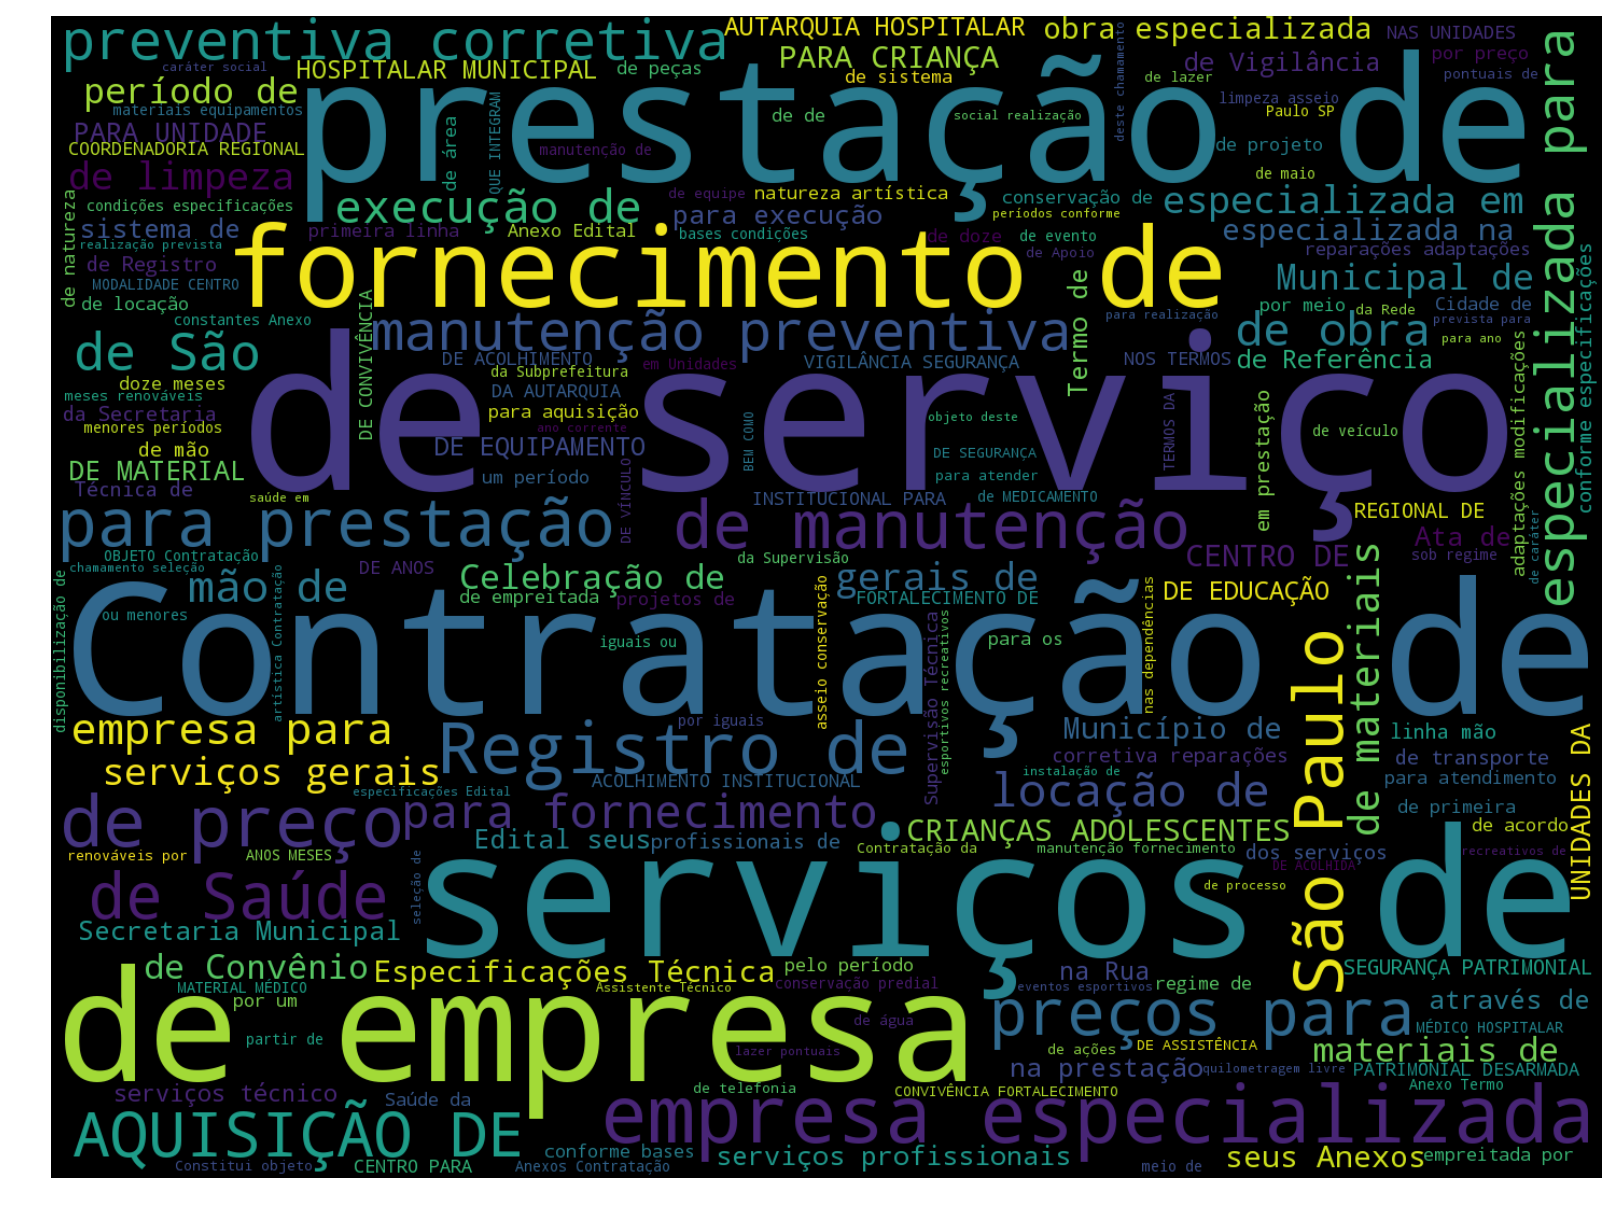

In [20]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(lics_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### 2. Análise Semântica

Abaixo identificamos algumas características semânticas do objeto, e confirmamos que a maioria dos contratos se referem a serviços.

In [46]:
qmarks = np.mean(lics_qs.apply(lambda x: ',' in x))
fullstop = np.mean(lics_qs.apply(lambda x: '.' in x))
capital_first = np.mean(lics_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(lics_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(lics_qs.apply(lambda x: max([y.isdigit() for y in x])))
prestac = np.mean(lics_qs.apply(lambda x: ('prestaç' in x.lower()) and not ('contrataç' in x.lower())))
contratac = np.mean(lics_qs.apply(lambda x: not ('prestaç' in x.lower()) and ('contrataç' in x.lower())))
prest_contr1 = np.mean(lics_qs.apply(lambda x: ('prestaç' in x.lower()) and ('contrataç' in x.lower())))
prest_contr2 = np.mean(lics_qs.apply(lambda x: ('prestaç' in x.lower()) or ('contrataç' in x.lower())))
prest_contr3 = np.mean(lics_qs.apply(lambda x: ('prestaç' in x.lower()) or ('contrataç' in x.lower()) 
                                     or ('serviço' in x.lower()) or ('manutenção' in x.lower()) 
                                     or ('execução' in x.lower()) or ('celebração' in x.lower())
                                     or ('vigilância' in x.lower()) or ('mão de' in x.lower()) ))

print('Objetos com vírgulas: {:.2f}%'.format(qmarks * 100))
print('Objetos com pontos: {:.2f}%'.format(fullstop * 100))
print('Objetos com letras maiuscúlas no início: {:.2f}%'.format(capital_first * 100))
print('Objetos com letras maiuscúlas: {:.2f}%'.format(capitals * 100))
print('Objetos com números: {:.2f}%'.format(numbers * 100))
print('Objetos que possuem a palavra "prestação" exceto a palavra "contratação" : {:.2f}%'.format(prestac * 100))
print('Objetos que possuem a palavra "contratação" exceto a palavra "prestação" : {:.2f}%'.format(contratac * 100))
print('Objetos que possuem as palavras "prestação" e "contratação": {:.2f}%'.format(prest_contr1 * 100))
print('Objetos que possuem as palavras "prestação" ou "contratação": {:.2f}%'.format(prest_contr2 * 100))
print('Objetos que possuem: "prestação" ou "contratação" ou "serviço" ou "manutenção" ou "execução" ou "celebração" ou "vigilância" ou "mão de": {:.2f}%'.format(prest_contr3 * 100))

Objetos com vírgulas: 46.46%
Objetos com pontos: 53.51%
Objetos com letras maiuscúlas no início: 93.45%
Objetos com letras maiuscúlas: 98.17%
Objetos com números: 28.03%
Objetos que possuem a palavra "prestação" exceto a palavra "contratação" : 10.60%
Objetos que possuem a palavra "contratação" exceto a palavra "prestação" : 18.25%
Objetos que possuem as palavras "prestação" e "contratação": 15.13%
Objetos que possuem as palavras "prestação" ou "contratação": 43.98%
Objetos que possuem: "prestação" ou "contratação" ou "serviço" ou "manutenção" ou "execução" ou "celebração" ou "vigilância" ou "mão de": 62.81%
